### Soud recognition

Importing necessary libraries

In [1]:
from scipy.io import wavfile
from scipy.signal import butter, lfilter

import pyaudio
import math
import wave
import numpy as np
import matplotlib.pyplot as plt
import os

Initialising the parameters and preparing for reading data.

In [2]:
chunk = 1024

songs = [
    "Interpol - Obstacle 1",
    "The xx - On Hold",
    "Coldplay - Fix You"
]

notebook_path = os.path.abspath("Sound Recognition.ipynb")
file_path = os.path.join(os.path.dirname(notebook_path), "songs\\test\\" + songs[2] + ".wav")

# open up a wave
wf = wave.open(file_path, 'rb')

# sample width and framerate and number of channels
sample_width = wf.getsampwidth()
sampling_rate = wf.getframerate()
number_frames = wf.getnframes()
sample_channels = wf.getnchannels()

sampling_freq = 0
bin_freq = 0

# hamming window 1024 samples
window = np.hamming(chunk)

def sampling_details(chunk, sampling_rate):
    global sampling_freq
    sampling_freq = (chunk / sampling_rate)
    print("Sampling at a frequency of: %.4f hz" % sampling_freq)

    global bin_freq
    bin_freq = (sampling_rate / chunk)
    print("Frequency resolution for each frequency bin: %.4f hz" % bin_freq)
    
sampling_details(chunk, sampling_rate)

Sampling at a frequency of: 0.0232 hz
Frequency resolution for each frequency bin: 43.0664 hz


Reading the data and parsing it

In [3]:
# opening stream
p = pyaudio.PyAudio()
stream = p.open(format = p.get_format_from_width(sample_width),
                channels = sample_channels,
                rate = sampling_rate,
                output = True)

# storing the data
out_data = []

# multichannel conversion to mono
def multi_to_mono(data):
    output = np.zeros(int(len(data) /  sample_channels))
    for c in range(sample_channels):
        # each nth is n channel where data is [0 .. n 0 .. n 0 .. n ...] 
        output += list(data[c: :sample_channels])
        
    output /= sample_channels
    
    return output.tolist()

# DOWNSAMPLING PART ***************************

# downsampling factor
downsampling_factor = 4

# new sampling rate after downsampling
sampling_rate_new = sampling_rate / downsampling_factor

# new hamming window with 512 samples
window = np.hamming(chunk / downsampling_factor)

# new sample len
new_chunk = int(chunk / downsampling_factor)

sampling_details(new_chunk, sampling_rate_new)

def downsampling(data):
    return (data[: 256] + data[256 : 512] \
        + data[512 : 768] + data[768 : 1024]) / 4


# FILTERING PART ***************************

# order of the filter
order = 6

nyquist_freq = 0.5 * sampling_rate

normal_cutoff = sampling_rate_new / nyquist_freq

b, a = butter(order, normal_cutoff, btype = 'low', analog = False)

# low pass filter
def low_pass_filter(data):
    return lfilter(b, a, data)

# half output
S = int(new_chunk * sample_width / 2)

# amplitude extractor from the dft data by taking the magnitude of a complex number 
magnitude_extractor = lambda x : np.sqrt(np.real(x) ** 2 + np.imag(x) ** 2) / S


# READING PART ***************************

# reading data
data = wf.readframes(chunk)

# playing stream and applying fft for each chunk
while len(data) == chunk * sample_width * 2:
    # write data out to the audio stream
    stream.write(data)
    
    # unpack the data and parsing it
    unpacked_data = wave.struct.unpack("%dh" % (len(data) / sample_width), data)
    
    # conversion from multichannel input to mono output
    mono_data = multi_to_mono(unpacked_data)
    
    # filtering and downsampling:
    # filtering the data
    filtered_data = low_pass_filter(mono_data)
    
    # downsampling the data
    downsampled_data = downsampling(filtered_data)
    
    # times by the hamming window
    in_data = downsampled_data * window
    
    # taking the fft of the input signal, taking half as the latter is uncessary
    fft_output = np.fft.fft(in_data)[:S]
    
    # extracting the amplitude
    fft_data = magnitude_extractor(fft_output)
    
    # appending gathered data
    out_data += fft_data.tolist()
        
    # read more data that remains
    data = wf.readframes(chunk)
    
    
if data:
    stream.write(data)
    
stream.close()
p.terminate()

Sampling at a frequency of: 0.0232 hz
Frequency resolution for each frequency bin: 43.0664 hz


Spectogram related to the audio source

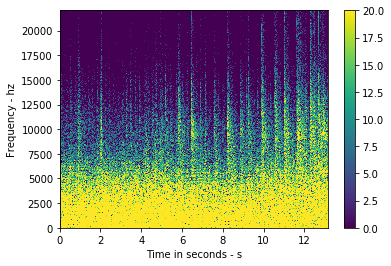

In [4]:
def multi_dimen_to_mono(data):
    nb_channels = data.shape[1]
    output = np.zeros(data.shape[0])
    for c in range(nb_channels):
        output += data[:, c]
    
    return abs(output / nb_channels)

_, samples = wavfile.read(file_path)
output = multi_dimen_to_mono(samples)

plt.specgram(output, NFFT = chunk * 2, Fs = sampling_rate, noverlap = 800)
plt.clim(0, 20)
plt.colorbar()
plt.xlabel("Time in seconds - s")
plt.ylabel("Frequency - hz")
plt.show()

Band 0 - from 0.000 hz to 73.403 hz
Band 1 - from 73.403 hz to 150.198 hz
Band 2 - from 150.198 hz to 307.339 hz
Band 3 - from 307.339 hz to 628.883 hz
Band 4 - from 628.883 hz to 1286.832 hz
Band 5 - from 1286.832 hz to 2633.142 hz
Band 6 - from 2633.142 hz to 5387.985 hz
Band 7 - from 5387.985 hz to 11025.000 hz


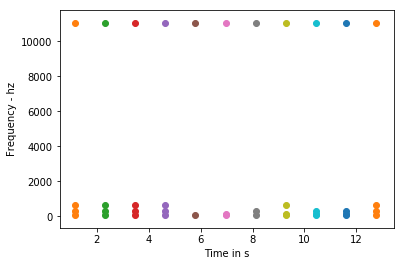

In [5]:
# offset_band because logarithm derivative is low in the beginning
offset_band = 6
count_band = 8
ceil_band = (offset_band + count_band)

# we substract one to get even 8 band ranges
base = np.power(sampling_rate_new, 1 / (ceil_band - 1))

# store band' frequency coverage
bands = [ base ** x for x in range(offset_band, ceil_band - 1) ]

message = "Band %d - from %.3f hz to %.3f hz"

print(message % (0, 0, bands[0]))
[ print(message % ((i - offset_band + 1), base ** i, base ** (i + 1))) for i in range(offset_band, (ceil_band -1)) ]
    
# getting the corresponding band based on freq
min_bin = base ** offset_band

def get_band(value):
    if value > min_bin:
        return math.floor(math.log(value, base) - offset_band + 1)
    else: return 0
    
class Band:
    def __init__(self, index, mag):
        self.index = index
        self.mag = mag
    
    
# we compute the strongest bins for the bands
output_bands = []

for i in range(0, len(out_data), new_chunk):
    max_band = np.zeros(count_band)
    
    for g in range(new_chunk):
        current_band = get_band(g * bin_freq)
        
        
        max_band[current_band] = max(max_band[current_band], out_data[g + i])
        
    # compute the average for the list of bands
    average = np.average(max_band).tolist()
        
    # filter the bands the exceed the average value
    output_bands_filtered = [ Band(index, mag) for index, mag in enumerate(max_band) if mag > average ]
        
    output_bands.append(output_bands_filtered)

    
output_freq = [ [ base ** (band.index + offset_band)  for band in bands ] for bands in output_bands]


down_scaler = 50
for index, values in enumerate(output_freq[: : down_scaler]):
    plt.scatter([index * sampling_freq * down_scaler] * len(values), values)

plt.xlabel("Time in s")
plt.ylabel("Frequency - hz")
plt.show()